<a href="https://colab.research.google.com/github/Near32/SymbolicBehaviourBenchmark/blob/main/data_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup :

In [7]:
!git clone https://github.com/Near32/SymbolicBehaviourBenchmark ; cd SymbolicBehaviourBenchmark; git pull

fatal: destination path 'SymbolicBehaviourBenchmark' already exists and is not an empty directory.
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/Near32/SymbolicBehaviourBenchmark
   ced68ae..5bd932f  main       -> origin/main
Updating ced68ae..5bd932f
Fast-forward
 symbolic_behaviour_benchmark/envs/communication_channel.py | 9 +++++----
 1 file changed, 5 insertions(+), 4 deletions(-)


In [3]:
!pip install -e SymbolicBehaviourBenchmark/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/SymbolicBehaviourBenchmark
     |████████████████████████████████| 626 kB 14.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.23.1-py3-none-any.whl size=701377 sha256=903c4022e25598a3dacca15e8837e4d348420810f175d14dee4e27a3a6c47012
  Stored in directory: /root/.cache/pip/wheels/e3/33/04/6723848e46f0f1ebe794bb329b7c761c3329a0d7ffade99da7
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
  Running setup.py develop for SymbolicBehaviourBenchmark


In [4]:
!pip install seaborn pandas matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Gathering Data:

In [1]:
import pandas as pd
import numpy as np 

import symbolic_behaviour_benchmark
import gym

env_name = "SymbolicBehaviourBenchmark-ReceptiveConstructiveTestEnv-v0"
config = {
    "nbr_shots":1,
    "nbr_communication_rounds": 1,
    "vocab_size": 6,
    "max_sentence_length": 3,
    "descriptive": True,
    "nbr_latents": 3,
    "min_nbr_values_per_latent": 2,
    "max_nbr_values_per_latent": 3,
    "nbr_object_centric_samples": 16,
    "nbr_distractors": 0,
    "use_communication_channel_permutations": True,
    "allow_listener_query": False,
    "provide_listener_feedback": True,
    "sampling_strategy": "component-focused-2shots",
}

env = gym.make(env_name, **config)

In [2]:
env.unwrapped.__dict__

{'_np_random': RandomNumberGenerator(PCG64) at 0x7F5C36850350,
 'action_space': Dict(communication_channel:CommunicationChannel([7 7 7]), decision:Discrete(2)),
 'allow_listener_query': False,
 'communication_channel_action_space': CommunicationChannel([7 7 7]),
 'communication_channel_observation_space': CommunicationChannel([7 7 7]),
 'datasets': {'test': <symbolic_behaviour_benchmark.utils.dual_labeled_dataset.DualLabeledDataset at 0x7f5cb0c6bb10>,
  'train': <symbolic_behaviour_benchmark.utils.dual_labeled_dataset.DualLabeledDataset at 0x7f5cba78d410>},
 'decision_space': Discrete(2),
 'feedback_provided': False,
 'id_length': 10,
 'listener_feedback': True,
 'max_sentence_length': 3,
 'mode': 'train',
 'mode_id_observation_space': MultiBinary(2),
 'nbr_communication_rounds': 1,
 'nbr_distractors': 0,
 'nbr_latents': 3,
 'nbr_players': 2,
 'nbr_shots': 1,
 'observation_space': Dict(communication_channel:CommunicationChannel([7 7 7]), mode_id:MultiBinary(2), other_agent_id:Box(0, 25

In [3]:
env.unwrapped.rg_config

{'curriculum_distractors_window_size': 25,
 'descriptive': True,
 'descriptive_target_ratio': 0.5,
 'distractor_sampling': 'uniform',
 'graphtype': 'reinforce-like',
 'gumbel_softmax_eps': 1e-06,
 'max_sentence_length': 3,
 'nbr_communication_rounds': 1,
 'nbr_distractors': 0,
 'nbr_experience_repetition': 1,
 'nbr_latents': 3,
 'nbr_stimulus': 1,
 'object_centric': True,
 'observability': 'full',
 'tau0': 0.2,
 'unsupervised_segmentation_factor': None,
 'use_curriculum_nbr_distractors': False,
 'vocab_size': 6}

In [4]:
env.action_space

Dict(communication_channel:CommunicationChannel([7 7 7]), decision:Discrete(2))

In [5]:
env.observation_space

Dict(communication_channel:CommunicationChannel([7 7 7]), mode_id:MultiBinary(2), other_agent_id:Box(0, 255, (10,), uint8), previous_game_result:MultiBinary(2), previous_game_reward:Box(-10.0, 10.0, (1,), float32), role_id:MultiBinary(2), stimulus:Box(-1.0, 1.0, (3,), float32))

In [6]:
samples = []
dimensions = []
steps = []
values = []
latent_ids = []
rg_id = []

latent_strides = [1]
dims = [config['max_nbr_values_per_latent'] for _ in range(config['nbr_latents'])]
for idx in range(config['nbr_latents']):
    latent_strides.append(np.prod(dims[-idx-1:]))
latent_strides = list(reversed(latent_strides[:-1]))
print(latent_strides)

def coord2idx(coord):
    idx = 0
    for stride, mult in zip(latent_strides,coord):
        idx += stride*mult
    return idx

obs, info = env.reset()

done = False
iteration = 0
rg_idx = 0
while not done:
    iteration += 1
    speaker_action = env.action_space.sample()
    listener_action = env.action_space.sample()
    action = (speaker_action, listener_action)
    obs, rewards, done, infos = env.step(action)
    samples.append({'obs':obs, 'r':rewards, 'done':done, 'infos':infos})
    if infos[0]['round_idx'] == -1:
        rg_idx +=1
        for lidx, value in enumerate(obs[0]["stimulus"]):
            dimensions.append(lidx)
            #latent_id = coord2idx(infos[0]["speaker_exp_latents"][0,0])
            latent_id = infos[0]["speaker_exp_latents"][0,0,lidx]
            latent_ids.append(latent_id)
            values.append(value.item())
            steps.append(iteration)
            rg_id.append(rg_idx)


[9, 3, 1]


/content/SymbolicBehaviourBenchmark/symbolic_behaviour_benchmark/utils/dataset.py:143: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  v = torch.Tensor(v)
/usr/local/lib/python3.7/dist-packages/gym/utils/seeding.py:28: DeprecationWarning: WARN: Function `rng.rand(*size)` is marked as deprecated and will be removed in the future. Please use `Generator.random(size)` instead.
  "Function `rng.rand(*size)` is marked as deprecated "


In [7]:
print(len(steps))

66


In [8]:
print(infos[0])

{'speaker_exp_latents': array([[[1., 1., 2.]]], dtype=float32), 'listener_exp_latents': array([[[1., 1., 2.]]], dtype=float32), 'round_id': array([[0., 0.]]), 'nbr_communication_rounds': 1, 'round_idx': -1, 'stimulus_idx': 12, 'step_idx': 65, 'mode': 'test', 'end_of_mode': True, 'nbr_successes': 10, 'nbr_games': 13, 'running_accuracy': 76.92307686390532}


In [9]:
dd = {
    "dim":dimensions, 
    "stimulus":values,
    "steps":steps,
    "x":[0 for _ in range(len(steps))],
    "latent_id": latent_ids,
    "rg_id":rg_id,
}

for k,v in dd.items():
    print(k,len(v))

df = pd.DataFrame(dd)

dim 66
stimulus 66
steps 66
x 66
latent_id 66
rg_id 66


In [10]:
df.describe()

,dim,stimulus,steps,x,latent_id,rg_id
count,66.000000,66.000000,66.000000,66.0,66.000000,66.000000
mean,1.000000,0.007544,33.500000,0.0,0.848485,11.500000
std,0.822753,0.473909,19.178714,0.0,0.684834,6.392905
min,0.000000,-0.867715,2.000000,0.0,0.000000,1.000000
25%,0.000000,-0.393723,17.000000,0.0,0.000000,6.000000
50%,1.000000,-0.007559,33.500000,0.0,1.000000,11.500000
75%,2.000000,0.412257,50.000000,0.0,1.000000,17.000000
max,2.000000,0.679982,65.000000,0.0,2.000000,22.000000


# Visualisation :

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt 

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


'\ngrid.plot_marginals(\n    sns.rugplot, \n    height=1, \n    color="g", \n    alpha=.6,\n)\n'

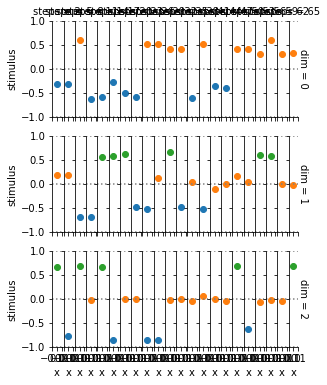

In [18]:
# Initialize a grid of plots with an Axes for each walk
#grid = sns.displot(
grid = sns.FacetGrid(
    data=df, 
    #x='x',
    #y='stimulus',
    col="steps", 
    row="dim", 
    #palette="tab20c",
    hue="latent_id",
    #col_wrap=4, 
    height=2,
    aspect=0.1,
    sharey=True,
    sharex=True,
    #despine=True,
    margin_titles=True,

    #kind="kde", 
    #rug=True,
)

    
# Draw a horizontal line to show the starting point
grid.refline(y=-1, linestyle=":")
grid.refline(y=0, linestyle=":")
grid.refline(y=1, linestyle=":")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.scatter, "x", "stimulus", marker="o")

# Adjust the tick positions and labels
grid.set(
    #xticks=np.arange(5), 
    #yticks=[-3, 3],
    xlim=(-0.1, 0.1), 
    ylim=(-1.0, 1.0),
)

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=0.5, h_pad=2.0)

#g.set_axis_labels("", "")
"""
grid.plot_marginals(
    sns.rugplot, 
    height=1, 
    color="g", 
    alpha=.6,
)
"""

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


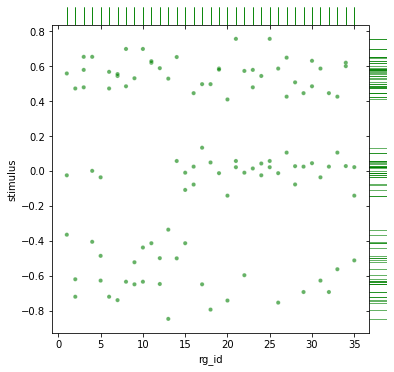

In [190]:
g = sns.JointGrid(
    data=df, 
    x="rg_id", 
    y="stimulus", 
    #row="dimensions",
    #col="steps",
    space=0, 
    ratio=17,
)

g.plot_joint(
    sns.scatterplot, 
    size=20,#mpg["horsepower"], 
    #sizes=(30, 120),
    color="g", 
    alpha=.6, 
    legend=False,
)

g.plot_marginals(
    sns.rugplot, 
    height=1, 
    color="g", 
    alpha=.6,
)

In [191]:
df.columns

Index(['dim', 'stimulus', 'steps', 'x', 'latent_id', 'rg_id'], dtype='object')

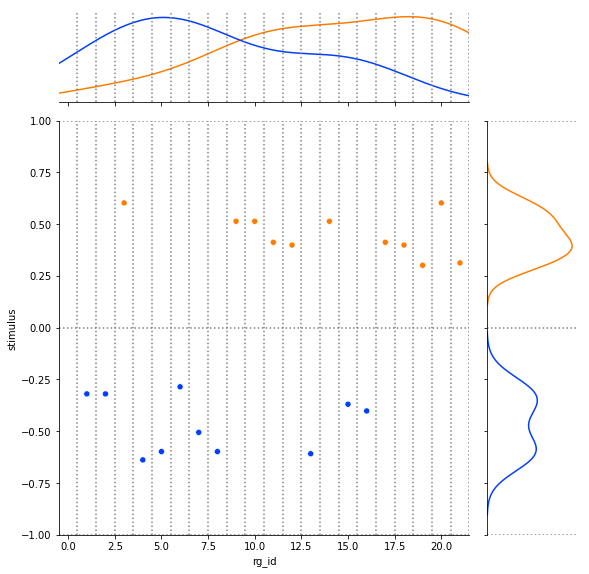

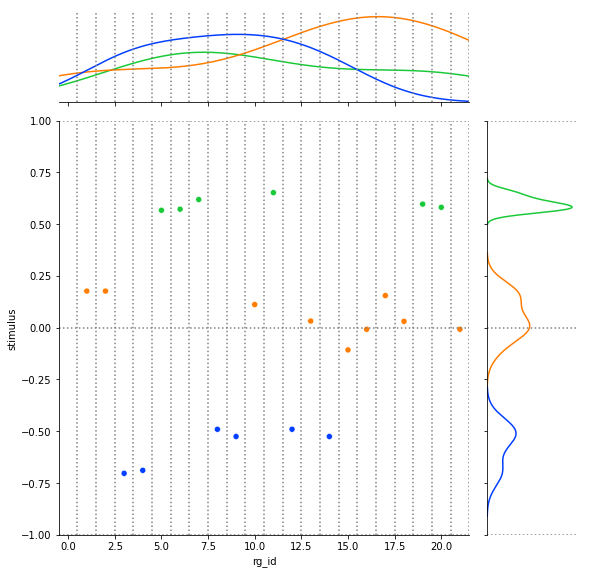

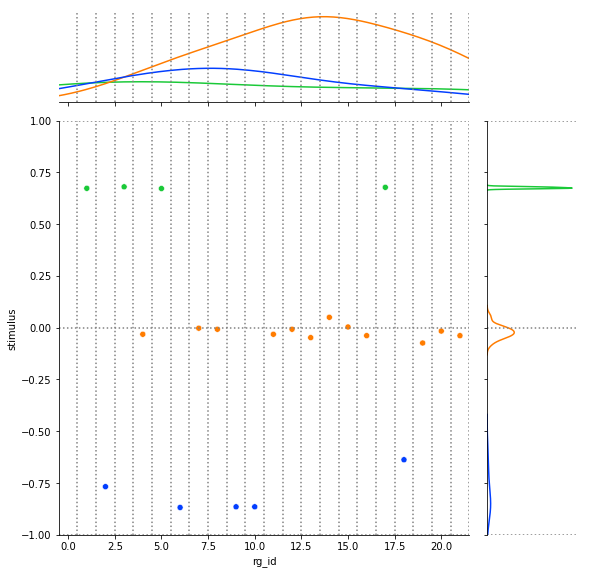

In [20]:
#fig, axes = plt.subplots(config['nbr_latents'], 1, sharex=True, sharey=True)# figsize=(16,8))
#sns.set_palette("bright")
nbr_values_per_latent = [2,3,3]

for lidx in range(config['nbr_latents']):
    #sns.set_palette("bright")
    g = sns.JointGrid(
        data=df[df.dim==lidx], 
        x="rg_id", 
        y="stimulus", 
        hue="latent_id",
        #palette=sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True),
        palette=sns.color_palette("bright", n_colors=nbr_values_per_latent[lidx]),
        height=8,
        ratio=4,
    )
    #g.plot(sns.scatterplot, sns.histplot)
    g.plot(
        sns.scatterplot, 
        sns.kdeplot, 
        legend=False,
    )
    #sns.kdeplot(y=df.stimulus, linewidth=2, ax=g.ax_marg_y)
    for rgid in range(len(rg_id)):
        g.refline(x=rgid+0.5, linestyle=":")
    g.ax_joint.set_xlim(left=-0.5, right=rgid//3+0.5) 
    g.ax_joint.set_ylim(bottom=-1.0,top=1.0)

    g.refline(y=-1, linestyle=":")
    g.refline(y=0, linestyle=":")
    g.refline(y=1, linestyle=":")
    g.fig.legend([],[], frameon=False)
    plt.savefig(f"./ld{lidx}.svg", dpi=1200)